## Learning to learn with quantum neural networks via classical neural networks

@paper https://arxiv.org/pdf/1907.05415.pdf
@paper "Variational quantum algorithms"  https://arxiv.org/pdf/2012.09265.pdf
@article "Barren plateaus in quantum neural network training landscapes" https://www.nature.com/articles/s41467-018-07090-4
@wiki "Maximum cut" https://en.wikipedia.org/wiki/Maximum_cut

This porgramm is a combination of classical machine learning and variational quantum algorithms to find extrama and the local minima for the cost.

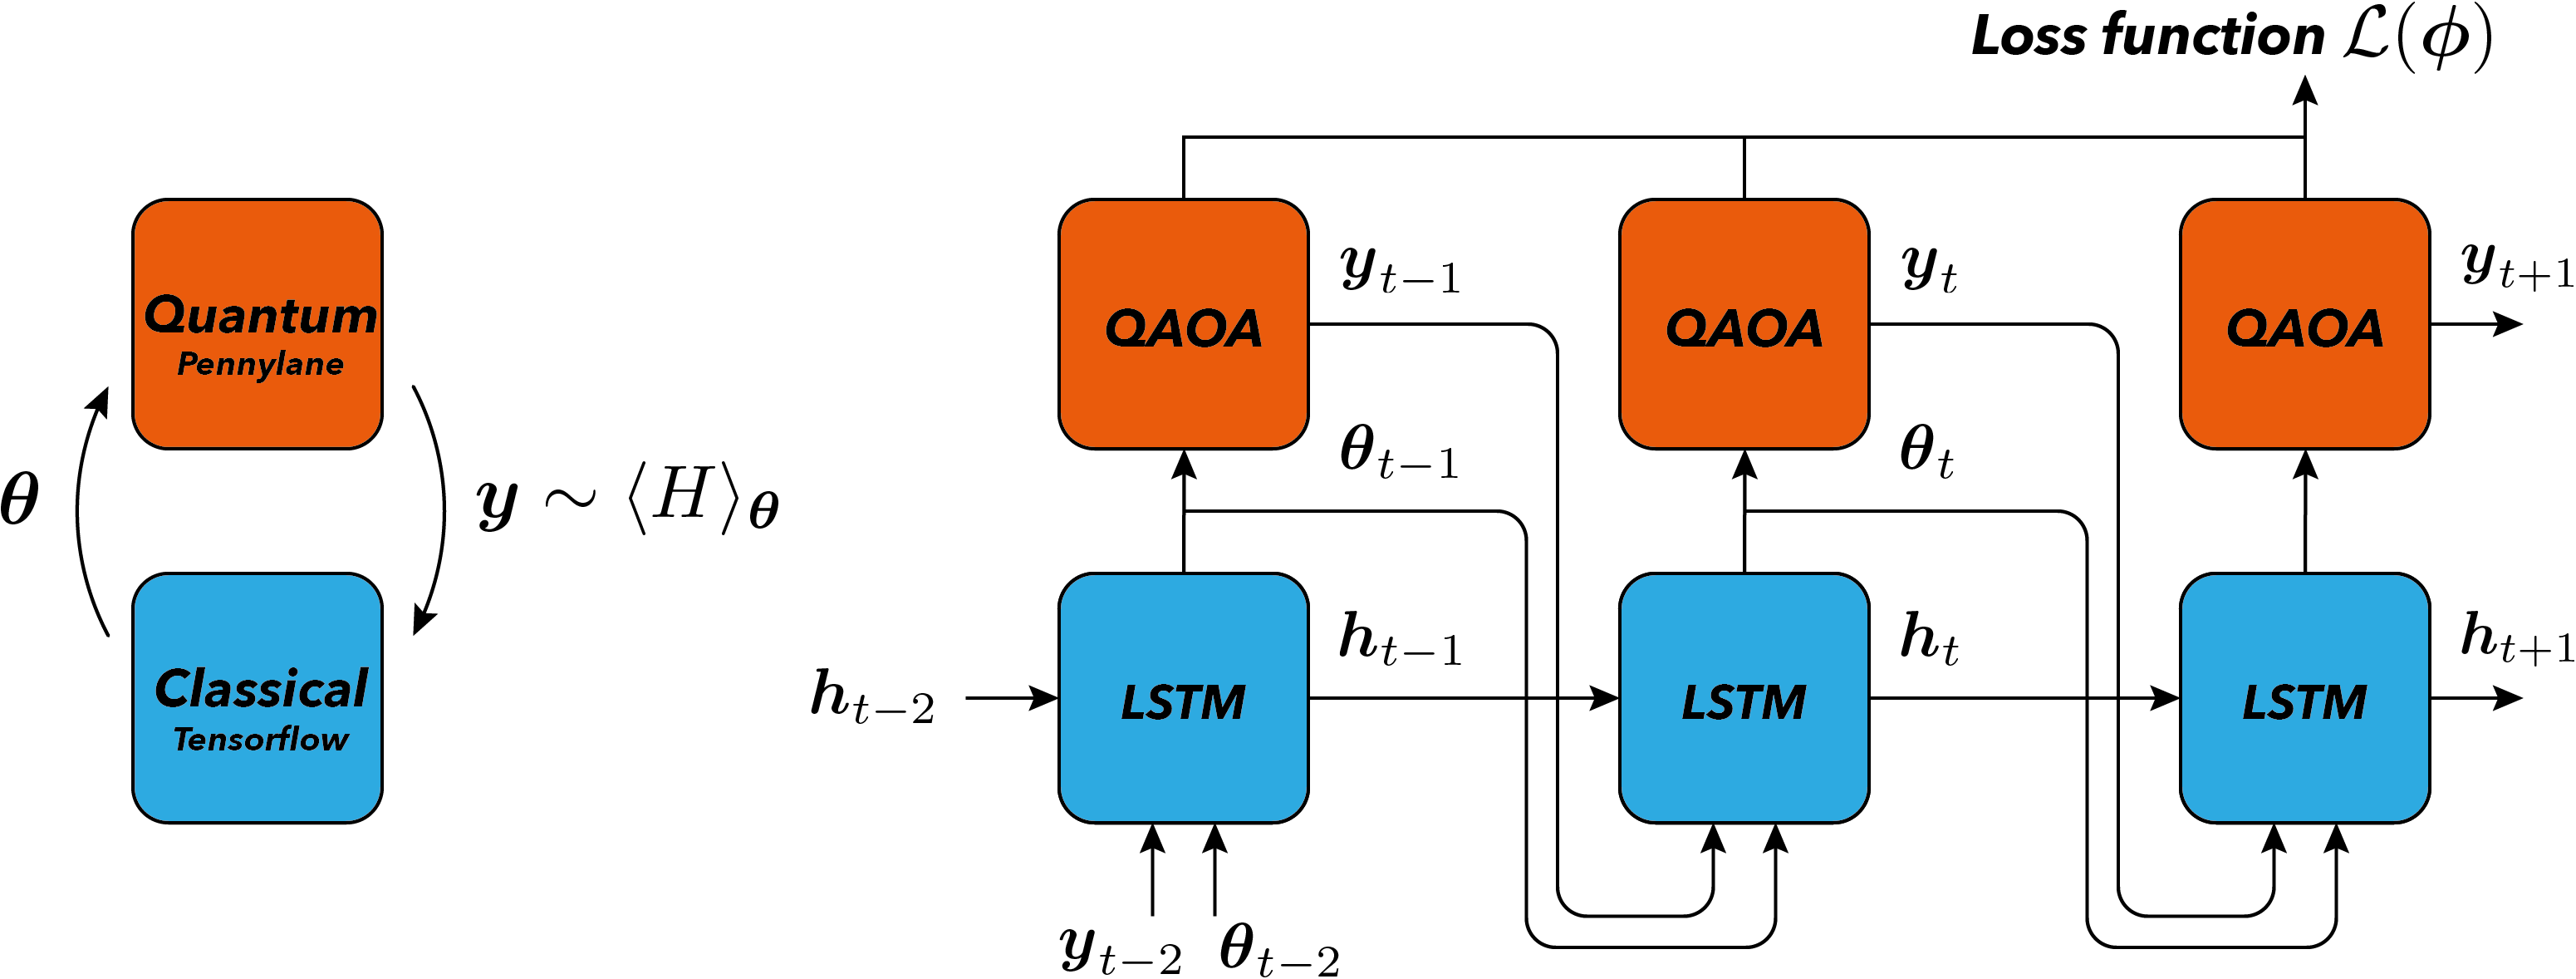


In [2]:
# Quantum Machine Learning
import pennylane as qml
from pennylane import qaoa

# Classical Machine Learning
import tensorflow as tf

# Generation of graphs
import networkx as nx

# Standard Python libraries
import numpy as np
import matplotlib.pyplot as plt
import random

# Fix the seed for reproducibility, which affects all random functions in this demo
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [4]:
def generate_graphs(n_graphs, n_nodes, p_edge):
    """Generate a list containing random graphs generated by Networkx."""

    datapoints = []
    for _ in range(n_graphs):
        random_graph = nx.gnp_random_graph(n_nodes, p=p_edge)
        datapoints.append(random_graph)
    return datapoints

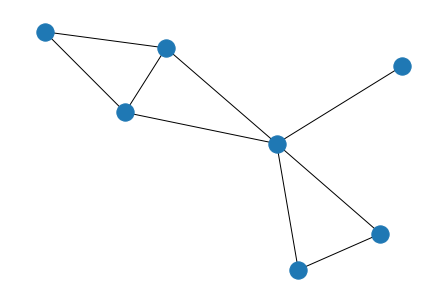

In [6]:
# Define parameters of the graphs
n_graphs = 20
n_nodes = 7
p_edge = 3.0 / n_nodes
graphs = generate_graphs(n_graphs, n_nodes, p_edge)

nx.draw(graphs[0])

In [7]:
def qaoa_from_graph(graph, n_layers=1):
    """Uses QAOA to create a cost Hamiltonian for the MaxCut problem."""

    # Number of qubits (wires) equal to the number of nodes in the graph
    wires = range(len(graph.nodes))

    # Define the structure of the cost and mixer subcircuits for the MaxCut problem
    cost_h, mixer_h = qaoa.maxcut(graph)

    # Defines a layer of the QAOA ansatz from the cost and mixer Hamiltonians
    def qaoa_layer(gamma, alpha):
        qaoa.cost_layer(gamma, cost_h)
        qaoa.mixer_layer(alpha, mixer_h)

    # Creates the actual quantum circuit for the QAOA algorithm
    def circuit(params, **kwargs):
        for w in wires:
            qml.Hadamard(wires=w)
        qml.layer(qaoa_layer, n_layers, params[0], params[1])
        return qml.expval(cost_h)

    # Evaluates the cost Hamiltonian
    def hamiltonian(params, **kwargs):
        """Evaluate the cost Hamiltonian, given the angles and the graph."""

        # We set the default.qubit.tf device for seamless integration with TensorFlow
        dev = qml.device("default.qubit.tf", wires=len(graph.nodes))

        # This qnode evaluates the expectation value of the cost hamiltonian operator
        cost = qml.QNode(circuit, dev, interface="tf", diff_method="backprop")

        return cost(params)

    return hamiltonian

In [9]:
# Create an instance of a QAOA circuit given a graph.
cost = qaoa_from_graph(graph=graphs[0], n_layers=1)

# Since we use only one layer in QAOA, params have the shape 1 x 2,
# in the form [[alpha, gamma]].
x = tf.Variable([[0.5], [0.5]], dtype=tf.float32)

# Evaluate th QAOA instance just created with some angles.
print(cost(x))

tf.Tensor(-2.434257557347492, shape=(), dtype=float64)


In [11]:
# Set the number of layers in the QAOA ansatz.
# The higher the better in terms of performance, but it also gets more
# computationally expensive. For simplicity, we stick to the single layer case.
n_layers = 1

# Define a single LSTM cell.
# The cell has two units per layer since each layer in the QAOA ansatz
# makes use of two parameters.
cell = tf.keras.layers.LSTMCell(2 * n_layers)

In [12]:
# We create the QAOA MaxCut cost functions of some graphs
graph_cost_list = [qaoa_from_graph(g) for g in graphs]

In [13]:
def rnn_iteration(inputs, graph_cost, n_layers=1):
    """Perform a single time step in the computational graph of the custom RNN."""

    # Unpack the input list containing the previous cost, parameters,
    # and hidden states (denoted as 'h' and 'c').
    prev_cost = inputs[0]
    prev_params = inputs[1]
    prev_h = inputs[2]
    prev_c = inputs[3]

    # Concatenate the previous parameters and previous cost to create new input
    new_input = tf.keras.layers.concatenate([prev_cost, prev_params])

    # Call the LSTM cell, which outputs new values for the parameters along
    # with new internal states h and c
    new_params, [new_h, new_c] = cell(new_input, states=[prev_h, prev_c])

    # Reshape the parameters to correctly match those expected by PennyLane
    _params = tf.reshape(new_params, shape=(2, n_layers))

    # Evaluate the cost using new angles
    _cost = graph_cost(_params)

    # Reshape to be consistent with other tensors
    new_cost = tf.reshape(tf.cast(_cost, dtype=tf.float32), shape=(1, 1))

    return [new_cost, new_params, new_h, new_c]


In [14]:
def recurrent_loop(graph_cost, n_layers=1, intermediate_steps=False):
    """Creates the recurrent loop for the Recurrent Neural Network."""

    # Initialize starting all inputs (cost, parameters, hidden states) as zeros.
    initial_cost = tf.zeros(shape=(1, 1))
    initial_params = tf.zeros(shape=(1, 2 * n_layers))
    initial_h = tf.zeros(shape=(1, 2 * n_layers))
    initial_c = tf.zeros(shape=(1, 2 * n_layers))

    # We perform five consecutive calls to 'rnn_iteration', thus creating the
    # recurrent loop. More iterations lead to better results, at the cost of
    # more computationally intensive simulations.
    out0 = rnn_iteration([initial_cost, initial_params, initial_h, initial_c], graph_cost)
    out1 = rnn_iteration(out0, graph_cost)
    out2 = rnn_iteration(out1, graph_cost)
    out3 = rnn_iteration(out2, graph_cost)
    out4 = rnn_iteration(out3, graph_cost)

    # This cost function takes into account the cost from all iterations,
    # but using different weights.
    loss = tf.keras.layers.average(
        [0.1 * out0[0], 0.2 * out1[0], 0.3 * out2[0], 0.4 * out3[0], 0.5 * out4[0]]
    )

    if intermediate_steps:
        return [out0[1], out1[1], out2[1], out3[1], out4[1], loss]
    else:
        return loss

In [15]:
def train_step(graph_cost):
    """Single optimization step in the training procedure."""

    with tf.GradientTape() as tape:
        # Evaluates the cost function
        loss = recurrent_loop(graph_cost)

    # Evaluates gradients, cell is the LSTM cell defined previously
    grads = tape.gradient(loss, cell.trainable_weights)

    # Apply gradients and update the weights of the LSTM cell
    opt.apply_gradients(zip(grads, cell.trainable_weights))
    return loss

In [16]:
# Select an optimizer
opt = tf.keras.optimizers.Adam(learning_rate=0.1)

# Set the number of training epochs
epochs = 5

for epoch in range(epochs):
    print(f"Epoch {epoch+1}")
    total_loss = np.array([])
    for i, graph_cost in enumerate(graph_cost_list):
        loss = train_step(graph_cost)
        total_loss = np.append(total_loss, loss.numpy())
        # Log every 5 batches.
        if i % 5 == 0:
            print(f" > Graph {i+1}/{len(graph_cost_list)} - Loss: {loss[0][0]}")
    print(f" >> Mean Loss during epoch: {np.mean(total_loss)}")

Epoch 1
 > Graph 1/20 - Loss: -1.37754225730896
 > Graph 6/20 - Loss: -1.7427994012832642
 > Graph 11/20 - Loss: -1.6540076732635498
 > Graph 16/20 - Loss: -1.6362755298614502
 >> Mean Loss during epoch: -1.5365245550870896
Epoch 2
 > Graph 1/20 - Loss: -1.668839693069458
 > Graph 6/20 - Loss: -1.889400839805603
 > Graph 11/20 - Loss: -1.788167953491211
 > Graph 16/20 - Loss: -1.6573913097381592
 >> Mean Loss during epoch: -1.6131415516138077
Epoch 3
 > Graph 1/20 - Loss: -1.7269290685653687
 > Graph 6/20 - Loss: -1.913464903831482
 > Graph 11/20 - Loss: -1.781661033630371
 > Graph 16/20 - Loss: -1.6518802642822266
 >> Mean Loss during epoch: -1.6244306594133378
Epoch 4
 > Graph 1/20 - Loss: -1.6967315673828125
 > Graph 6/20 - Loss: -1.9150164127349854
 > Graph 11/20 - Loss: -1.765077829360962
 > Graph 16/20 - Loss: -1.655194878578186
 >> Mean Loss during epoch: -1.6164413213729858
Epoch 5
 > Graph 1/20 - Loss: -1.6885744333267212
 > Graph 6/20 - Loss: -1.9061295986175537
 > Graph 11/2

In [17]:
new_graph = nx.gnp_random_graph(7, p=3 / 7)
new_cost = qaoa_from_graph(new_graph)

In [19]:
# Apply the RNN (be sure that training was performed)
res = recurrent_loop(new_cost, intermediate_steps=True)

# Extract all angle suggestions
start_zeros = tf.zeros(shape=(2 * n_layers, 1))
guess_0 = res[0]
guess_1 = res[1]
guess_2 = res[2]
guess_3 = res[3]
guess_4 = res[4]
final_loss = res[5]

# Wrap them into a list
guesses = [start_zeros, guess_0, guess_1, guess_2, guess_3, guess_4]

# Losses from the hybrid LSTM model
lstm_losses = [new_cost(tf.reshape(guess, shape=(2, n_layers))) for guess in guesses]

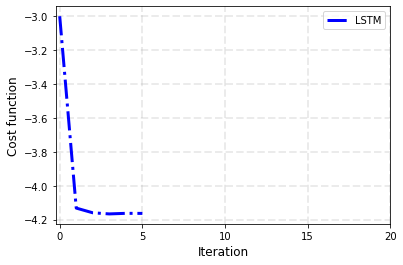

In [20]:
fig, ax = plt.subplots()

plt.plot(lstm_losses, color="blue", lw=3, ls="-.", label="LSTM")

plt.grid(ls="--", lw=2, alpha=0.25)
plt.ylabel("Cost function", fontsize=12)
plt.xlabel("Iteration", fontsize=12)
plt.legend()
ax.set_xticks([0, 5, 10, 15, 20]);
plt.show()

In [ ]:
# Parameters are randomly initialized
x = tf.Variable(np.random.rand(2, 1))

# We set the optimizer to be a Stochastic Gradient Descent
opt = tf.keras.optimizers.SGD(learning_rate=0.01)
step = 15

# Training process
steps = []
sdg_losses = []
for _ in range(step):
    with tf.GradientTape() as tape:
        loss = new_cost(x)

    steps.append(x)
    sdg_losses.append(loss)

    gradients = tape.gradient(loss, [x])
    opt.apply_gradients(zip(gradients, [x]))
    print(f"Step {_+1} - Loss = {loss}")

print(f"Final cost function: {new_cost(x).numpy()}\nOptimized angles: {x.numpy()}")

In [ ]:
fig, ax = plt.subplots()

plt.plot(sdg_losses, color="orange", lw=3, label="SGD")

plt.plot(lstm_losses, color="blue", lw=3, ls="-.", label="LSTM")

plt.grid(ls="--", lw=2, alpha=0.25)
plt.legend()
plt.ylabel("Cost function", fontsize=12)
plt.xlabel("Iteration", fontsize=12)
ax.set_xticks([0, 5, 10, 15, 20]);
plt.show()

## Generalization performances

In [ ]:
cell = tf.keras.layers.LSTMCell(2 * n_layers)

g7 = generate_graphs(5, 7, 3 / 7)
g8 = generate_graphs(5, 8, 3 / 7)
g9 = generate_graphs(5, 9, 3 / 7)

gs = g7 + g8 + g9
gs_cost_list = [qaoa_from_graph(g) for g in gs]

# Shuffle the dataset
import random
random.seed(1234)
random.shuffle(gs_cost_list)

In [ ]:
# Select an optimizer
opt = tf.keras.optimizers.Adam(learning_rate=0.1)

# Set the number of training epochs
epochs = 3

for epoch in range(epochs):
    print(f"Epoch {epoch+1}")
    total_loss = np.array([])
    for i, graph_cost in enumerate(gs_cost_list):
        loss = train_step(graph_cost)
        total_loss = np.append(total_loss, loss.numpy())
        # Log every 5 batches.
        if i % 5 == 0:
            print(f" > Graph {i+1}/{len(gs_cost_list)} - Loss: {loss}")
    print(f" >> Mean Loss during epoch: {np.mean(total_loss)}")

In [ ]:
new_graph = nx.gnp_random_graph(10, p=3 / 7)
new_cost = qaoa_from_graph(new_graph)

nx.draw(new_graph)

In [ ]:
res = recurrent_loop(new_cost, intermediate_steps=True)

# Extract all angle suggestions
start_zeros = tf.zeros(shape=(2 * n_layers, 1))
guess_0 = res[0]
guess_1 = res[1]
guess_2 = res[2]
guess_3 = res[3]
guess_4 = res[4]
final_loss = res[5]

# Wrap them into a list
guesses = [start_zeros, guess_0, guess_1, guess_2, guess_3, guess_4]

# Losses from the hybrid LSTM model
lstm_losses = [new_cost(tf.reshape(guess, shape=(2, n_layers))) for guess in guesses]

fig, ax = plt.subplots()

plt.plot(lstm_losses, color="blue", lw=3, ls="-.", label="LSTM")

plt.grid(ls="--", lw=2, alpha=0.25)
plt.legend()
plt.ylabel("Cost function", fontsize=12)
plt.xlabel("Iteration", fontsize=12)
ax.set_xticks([0, 5, 10, 15, 20]);
plt.show()

## Note

To get the optimized weights of the LSTM use: optimized_weights = cell.get_weights(). To set initial weights for the LSTM cell, use instead: cell.set_weights(optimized_weights).

Loss landscape in parameter space

Note

This cell takes approx. ~1m to run with an 11 by 11 grid

In [ ]:
# Evaluate the cost function on a grid in parameter space
dx = dy = np.linspace(-1.0, 1.0, 11)
dz = np.array([new_cost([[xx], [yy]]).numpy() for yy in dy for xx in dx])
Z = dz.reshape((11, 11))

# Plot cost landscape
plt.contourf(dx, dy, Z)
plt.colorbar()

# Extract optimizer steps
params_x = [0.0] + [res[i].numpy()[0, 0] for i in range(len(res[:-1]))]
params_y = [0.0] + [res[i].numpy()[0, 1] for i in range(len(res[:-1]))]

# Plot steps
plt.plot(params_x, params_y, linestyle="--", color="red", marker="x")

plt.yticks(np.linspace(-1, 1, 5))
plt.xticks(np.linspace(-1, 1, 5))
plt.xlabel(r"$\alpha$", fontsize=12)
plt.ylabel(r"$\gamma$", fontsize=12)
plt.title("Loss Landscape", fontsize=12)
plt.show()

In [ ]:
class QRNN(tf.keras.layers.Layer):
    def __init__(self, p=1, graph=None):
        super(QRNN, self).__init__()
        # p is the number of layers in the QAOA ansatz
        self.cell = tf.keras.layers.LSTMCell(2 * p)
        self.expectation = qaoa_from_graph(graph, n_layers=p)
        self.qaoa_p = p

    def call(self, inputs):
        prev_cost = inputs[0]
        prev_params = inputs[1]
        prev_h = inputs[2]
        prev_c = inputs[3]

        # Concatenate the previous parameters and previous cost to create new input
        new_input = tf.keras.layers.concatenate([prev_cost, prev_params])

        # New parameters obtained by the LSTM cell, along with new internal states h and c
        new_params, [new_h, new_c] = self.cell(new_input, states=[prev_h, prev_c])

        # This part is used to feed the parameters to the PennyLane function
        _params = tf.reshape(new_params, shape=(2, self.qaoa_p))

        # Cost evaluation, and reshaping to be consistent with other Keras tensors
        new_cost = tf.reshape(tf.cast(self.expectation(_params), dtype=tf.float32), shape=(1, 1))

        return [new_cost, new_params, new_h, new_c]

In [ ]:
_graph = nx.gnp_random_graph(7, p=3 / 7)

# Instantiate the LSTM cells
rnn0 = QRNN(graph=_graph)

# Create some input layers to feed the data
inp_cost = tf.keras.layers.Input(shape=(1,))
inp_params = tf.keras.layers.Input(shape=(2,))
inp_h = tf.keras.layers.Input(shape=(2,))
inp_c = tf.keras.layers.Input(shape=(2,))

# Manually creating the recurrent loops. In this case just three iterations are used.
out0 = rnn0([inp_cost, inp_params, inp_h, inp_c])
out1 = rnn0(out0)
out2 = rnn0(out1)

# Definition of a loss function driving the training of the LSTM
loss = tf.keras.layers.average([0.15 * out0[0], 0.35 * out1[0], 0.5 * out2[0]])

# Definition of a Keras Model
model = tf.keras.Model(
    inputs=[inp_cost, inp_params, inp_h, inp_c], outputs=[out0[1], out1[1], out2[1], loss]
)

model.summary()

In [ ]:
p = 1

inp_costA = tf.zeros(shape=(1, 1))
inp_paramsA = tf.zeros(shape=(1, 2 * p))
inp_hA = tf.zeros(shape=(1, 2 * p))
inp_cA = tf.zeros(shape=(1, 2 * p))

inputs = [inp_costA, inp_paramsA, inp_hA, inp_cA]

opt = tf.keras.optimizers.Adam(learning_rate=0.01)
step = 5

for _ in range(step):
    with tf.GradientTape() as tape:
        pred = model(inputs)
        loss = pred[3]

    gradients = tape.gradient(loss, model.trainable_variables)
    opt.apply_gradients(zip(gradients, model.trainable_variables))
    print(
        f"Step {_+1} - Loss = {loss} - Cost = {qaoa_from_graph(_graph, n_layers=p)(np.reshape(pred[2].numpy(),(2, p)))}"
    )

print("Final Loss:", loss.numpy())
print("Final Outs:")
for t, s in zip(pred, ["out0", "out1", "out2", "Loss"]):
    print(f" >{s}: {t.numpy()}")